# Neural Networks as Universal Approximators

## Basic Structure of a Neural Network

A neural network is a mathematical function that takes inputs, transforms them through layers of computation, and produces outputs. In a standard neural network:

1. Each input is multiplied by a set of weights, which are adjustable values, or *parameters*.
2. These weighted inputs are summed together and passed through an *activation function* that adds non-linearity to the network.
3. The outputs of one layer become the inputs to the next layer, repeating the process until we reach the final layer, which produces the network’s prediction.

The initial weights are typically set randomly, so a newly initialized neural network doesn’t perform any useful task—it behaves as a random function. The real magic of neural networks happens when we adjust these weights to improve the network’s performance on a specific task, a process called *training*.

## Training a Neural Network with Gradient Descent

To make a neural network useful, we need to find the best values for its parameters. This is done by **minimizing a loss function** (a measure of how far the model’s predictions are from the actual values). The process of minimizing the loss function is achieved through an algorithm such as **gradient descent**.

As previously discussed, gradient descent is an optimization technique that calculates the direction and magnitude of the change needed to reduce the loss. By iteratively adjusting the parameters based on the gradient, the model improves its predictions, ultimately learning the desired function.

In [1]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

### Understanding Gradient Descent with a Simple Quadratic Function

To see how gradient descent works, let’s start with a simple example: fitting a quadratic function. Quadratics are familiar mathematical functions that are easier to work with than neural networks. Here’s the quadratic we’ll try to approximate:

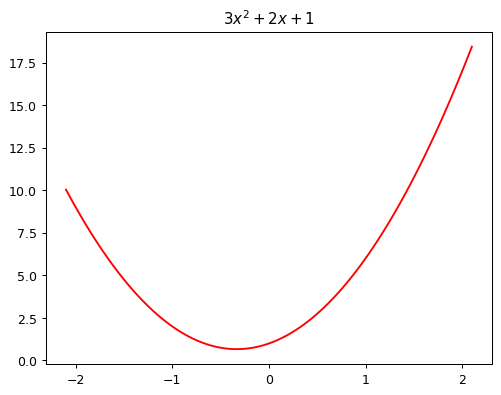

In [2]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

This quadratic is of the form $ax^2+bx+c$, with parameters $a=3$, $b=2$, $c=1$. To make it easier to try out different quadratics for fitting a model to the data we'll create, let's create a function that calculates the value of a point on any quadratic:

In [3]:
def quad(a, b, c, x): return a*x**2 + b*x + c

If we fix some particular values of a, b, and c, then we'll have made a quadratic. To fix values passed to a function in python, we use the `partial` function, like so:

In [4]:
def mk_quad(a,b,c): return partial(quad, a,b,c)

So for instance, we can recreate our previous quadratic:

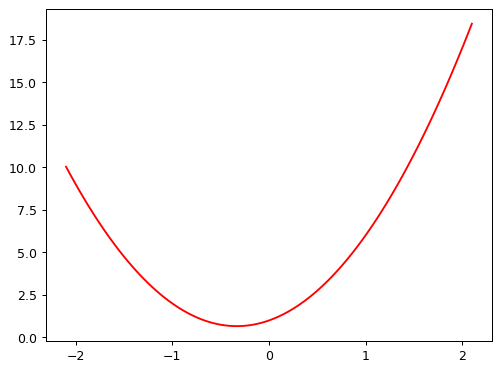

In [5]:
f2 = mk_quad(3,2,1)
plot_function(f2)

### Generating Noisy Data

Real-world data is never perfectly clean; it often contains noise. To simulate this, we’ll add random noise to the quadratic function values, creating a dataset that we’ll try to fit using gradient descent.

In [6]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

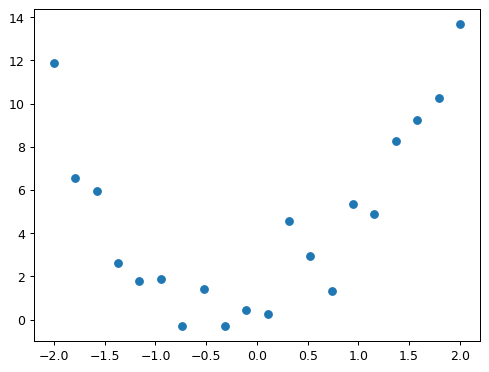

In [7]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

plt.scatter(x,y);

## 3. Manual Parameter Tuning

Before we dive into automated optimization, let’s experiment with manually adjusting parameters to see how they affect the model’s output. The code below provides sliders for adjusting the parameters $ a $, $ b $, and $ c $ to fit the data:

In [8]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

In [9]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

## Automating Parameter Tuning with Gradient Descent

To automate the optimization process, we need to compute the gradient of the loss with respect to each parameter. The gradient tells us how much each parameter needs to change to reduce the loss.

The basic idea is this: if we know the *gradient* of our `mae()` function *with respect to* our parameters, `a`, `b`, and `c`, then that means we know how adjusting (for instance) `a` will change the value of `mae()`. If, say, `a` has a *negative* gradient, then we know that increasing `a` will decrease `mae()`. Then we know that's what we need to do, since we trying to make `mae()` as low as possible.

So, we find the gradient of `mae()` for each of our parameters, and then adjust our parameters a bit in the *opposite* direction to the sign of the gradient.

In our example, we can define a function that calculates the loss for a given set of parameters:

In [10]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

Starting with some initial values for *a*, *b*, and *c*, we can iteratively adjust these values using the gradients. In PyTorch, gradients are computed using the `backward()` function:

In [11]:
abc = torch.tensor([1.1, 1.1, 1.1], requires_grad=True) # To tell PyTorch that we want it to calculate gradients for these parameters, we need to call `requires_grad_()`
loss = quad_mae(abc)
loss.backward()

with torch.no_grad():
    abc -= abc.grad * 0.01
    loss = quad_mae(abc)
    
print(f'Updated loss={loss:.2f}')


Updated loss=2.40


In this code, we subtract a small fraction of the gradient from each parameter to reduce the loss. This fraction is known as the *learning rate*, which controls the size of the steps taken towards minimizing the loss and it is the most important *hyper-parameter* to set when training a neural network.

### Iterative Optimization

Using a loop, we can apply this update process repeatedly, observing the loss decrease as the parameters converge towards the optimal values:

In [12]:
for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad(): # we call the `no_grad()` method to momentarly stop evaluating the gradient
        abc -= abc.grad * 0.01
    print(f'step={i}; loss={loss:.2f}')


step=0; loss=2.40
step=1; loss=2.36
step=2; loss=2.30
step=3; loss=2.21
step=4; loss=2.11
step=5; loss=1.98
step=6; loss=1.85
step=7; loss=1.72
step=8; loss=1.58
step=9; loss=1.46


If the learning rate is too high, the parameters might "jump" over the optimal values, causing the loss to oscillate or increase. To address this, we can gradually decrease the learning rate, a process called **learning rate scheduling**.

## Neural Networks as Flexible Function Approximators

While fitting a quadratic function is a simple example, neural networks are capable of much more. By combining multiple layers, each with its own parameters and activation functions, neural networks can approximate highly complex functions. This capability is central to the Universal Approximation Theorem, which states that a neural network with enough parameters can approximate any continuous function.

### The Building Blocks of Neural Networks
The two fundamental operations in neural networks are:

1. **Matrix Multiplication**: This involves multiplying inputs by weights and adding biases. In neural networks, this operation is the core of each layer’s computation.
2. **Activation Functions**: Non-linear functions, like the rectified linear unit (ReLU), allow the network to capture complex patterns. ReLU replaces negative values with zero, enabling the network to learn non-linear transformations.

Here’s a simple implementation of a rectified linear function (ReLU):

In [13]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

Here's what it looks like:

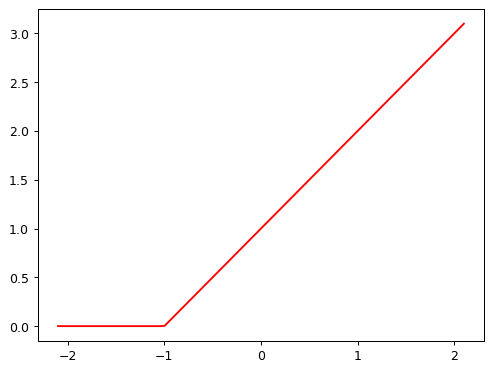

In [14]:
plot_function(partial(rectified_linear, 1,1))

To understand how this function works, try using this interactive version to play around with the parameters `m` and `b`:

In [15]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

As you see, `m` changes the slope, and `b` changes where the "hook" appears. This function doesn't do much on its own, but let's see what happens when we add two of them together:

In [16]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

By stacking and combining ReLU functions, neural networks can create intricate mappings between inputs and outputs. This allows them to approximate non-linear functions, which is essential for tasks like image recognition and natural language processing.

This exact same approach can be expanded to functions of 2, 3, or more parameters.

The basic idea is that by using multiple **linear layers** in a model, we allow it to perform more computations, thereby making it capable of modeling increasingly complex functions. However, if we simply stack one linear layer directly after another without any nonlinearity in between, it does not increase the expressive power of the model.

### Why Multiple Linear Layers Alone are Not Sufficient

Let’s break this down mathematically:

1. **Linear Transformation**: A linear layer performs a transformation on its input, given by:
   $$
   f(x) = W \cdot x + b
   $$
   where:
   - $ W $ is a matrix of weights,
   - $ x $ is the input vector, and
   - $ b $ is a bias vector.

2. **Composition of Linear Functions**: Suppose we apply two consecutive linear layers, $ f(x) = W_1 \cdot x + b_1 $ and $ g(x) = W_2 \cdot f(x) + b_2 $. Expanding $ g(x) $ yields:
   $$
   g(x) = W_2 \cdot (W_1 \cdot x + b_1) + b_2
   $$
   This simplifies to:
   $$
   g(x) = (W_2 \cdot W_1) \cdot x + (W_2 \cdot b_1 + b_2)
   $$
   which is again a linear transformation of $ x $. Thus, applying multiple linear layers in sequence still results in a single linear transformation. 

> **Mathematical Insight**: The composition of two linear transformations is itself a linear transformation. Therefore, stacking multiple linear layers without any nonlinear activation functions in between results in a model no more expressive than a single linear layer.

### Adding Nonlinearity: The Key to Complex Representations

To overcome this limitation, we introduce a **nonlinear function**, also known as an **activation function**, between the layers. This breaks the linearity of the transformation chain and allows each layer to learn different aspects of the data.

Consider the **ReLU (Rectified Linear Unit)** activation function, which is one of the simplest and most effective nonlinear functions in deep learning. ReLU is defined as:
$$
\text{ReLU}(z) = \max(0, z)
$$
where $ z = W \cdot x + b $.

ReLU has two important properties:
1. **Nonlinearity**: By setting negative values to zero, ReLU introduces a nonlinear element, which means that the composition of layers containing ReLU functions is no longer purely linear.
2. **Conditional Behavior**: The ReLU function can be thought of as a simple `if` statement that returns 0 for negative inputs and the input itself for positive inputs, effectively adding a decision-making element to each layer.

### Building Complex Models with Layers and Activation Functions

With this nonlinear function, we can build a network that consists of:
- A **sequence of linear transformations** (layers), each with its own set of weights and biases.
- **Activation functions** (such as ReLU) inserted between these layers to add complexity to the model’s behavior.

Consider a neural network with two layers:
1. **First Layer**: Applies a linear transformation, followed by a ReLU:
   $$
   h(x) = \text{ReLU}(W_1 \cdot x + b_1)
   $$
2. **Second Layer**: Applies another linear transformation to the output of the ReLU:
   $$
   f(x) = W_2 \cdot h(x) + b_2
   $$

Now, $ f(x) $ is no longer a simple linear function of $ x $; it is a composition of linear and nonlinear transformations, enabling it to capture much more complex patterns.

### The Universal Approximation Theorem

The addition of nonlinearity allows neural networks to approximate any continuous function to an arbitrary degree of accuracy, provided they have enough layers and units. This concept is formalized in the **Universal Approximation Theorem**, which states that:

> A neural network with at least one hidden layer containing a sufficient number of neurons, and a non-linear activation function, can approximate any continuous function on a compact subset of $\mathbb{R}^n$ to any desired accuracy.

This means that, theoretically, a neural network with just one hidden layer and a nonlinear activation function can approximate functions as complex as we need, given sufficient capacity.
